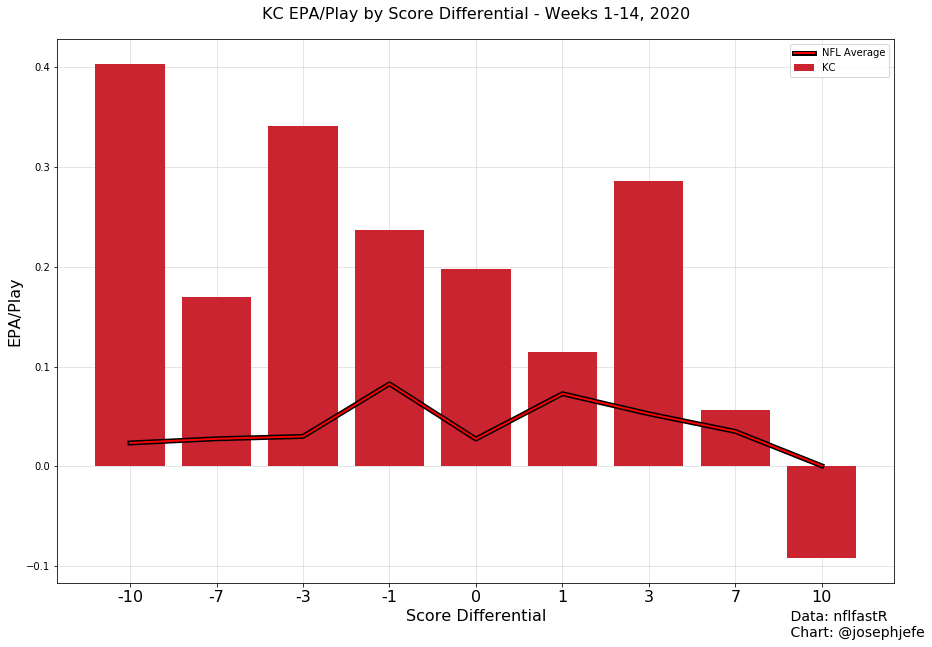

In [6]:
import pandas as pd
import numpy as np

filePath = '/Users/Firefly/Desktop/_iMac_Drive/Joseph/Coding/NFL/Jupyter/'

# Choose whether you want the 'raw_play_by_play' or 'cleaned_play_by_play' data 
#file = 'raw_play_by_play_'
file = 'cleaned_play_by_play_'

YEAR = 2020
myTeam = 'KC'

# Import data
data = pd.read_csv(filePath + file + str(YEAR) + '.csv.gz', compression='gzip', low_memory=False)

# These two lines set the scroll options so you can scroll vertically and horizontally.
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# assign week as a variable that returns the lastest week
minWeek = data['week'].min()
maxWeek = data['week'].max()

data = data.loc[data.season_type=='REG']

# Define colors for each team
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

# Create new colum for posteam score differential
data['posteam_diff'] = data['posteam_score'] - data['defteam_score']

# This function sets manual bins in which to put the posteam_diff
def func(row):
    if row['posteam_diff'] <= -10:
        return -10
    elif row['posteam_diff'] <= -7:
        return -7
    elif row['posteam_diff'] <= -3:
        return -3
    elif row['posteam_diff'] <= -1:
        return -1
    elif row['posteam_diff'] == 0:
        return 0
    elif row['posteam_diff'] <= 2:
        return 1
    elif row['posteam_diff'] <= 6:
        return 3
    elif row['posteam_diff'] <= 9:
        return 7
    elif row['posteam_diff'] >= 11:
        return 10
    else: 
        return 0

# Apply the function to the data as a new column
data['set_scores'] = data.apply(func, axis=1)

# Group your data by set_scores, find the mean of all teams epa, and reset the index
all_team_epa = (
    data.groupby(['set_scores'])[['epa']]
    .mean()
    .reset_index()
    .sort_values(by=['set_scores'], ascending=True)
    .reset_index(drop=True)
    )    

# Filter data to just myTeam and name that df team
team = data[data.posteam == myTeam]

# Group your data by set_scores, find the mean of your teams epa, and reset the index
team_epa = (
    team.groupby(['set_scores', 'posteam'])[['epa']]
    .mean()
    .reset_index()
    .sort_values(by=['set_scores'], ascending=True)
    .reset_index(drop=True)
    )

# Define colors for each team
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

# change COLORS dictionary into a df with names of posteam and color
colors = pd.DataFrame(list(COLORS.items()),columns = ['posteam','color'])

# join, or merge, team_epa df with colors df, then return the unique color
team_color = pd.merge(team_epa, colors, how = 'inner', on = 'posteam')
team_color = team_color.color.unique()

# Join, or merge, all_team_epa to team_epa, based on set_scores
# This is necessary to verify that every team will show all 9 ticks,
# even if that team hasn't yet been in that situation.
new_epa = pd.merge(all_team_epa, team_epa, how = 'outer', on = 'set_scores')

import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patheffects as pe

# # Find out what the max index number is and add 1, since np.arange() is non-inclusive
maxIndex = max(new_epa.index) + 1

#Create a figure with size 12x12 - (figsize=(x, y))
fig, ax = plt.subplots(figsize=(15,10))

# Make a bar plot first to get the points. This is a necessary step since we want to 
# specify our own ticks on the x axis. Otherwise it would be perfectly acceptable
# to just use the ax.bar(x, y) format and skip the set_tick steps below.
# Basically we are doing these three steps:
# 1. set the number of xticks to 9
# 2. assign those xticks based on the team_epa.index
# 3. label the xticks using the set_scores data item that corresponds to the index number
# np.arange(0,9) is setting the x axis to 9 points (its 0-8, as the 9 is non-inclusive)
# team_epa['epa']) is the y axis.
ax.bar(np.arange(0, maxIndex) ,new_epa['epa_y'], color=team_color, label=myTeam)

# Add a line plot to your bar graph to show nfl average epa
ax.plot(np.arange(0, maxIndex),new_epa['epa_x'], color='red', \
        lw=2, path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()], label='NFL Average')

plt.legend()

# With x axis set to 9 points, ax.set_xticks sets the labels to be based on 
# the index number of team_epa, which we sorted based on set_scored and reset 
# the index for above. 
# set_xticklabels is the point where we actually choose what the labels actually are
# (the values in set_scores, in this example)
ax.set_xticks(new_epa.index)
ax.set_xticklabels(new_epa.set_scores,fontsize=16)

#Add a grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)
    
#Adding labels and text
ax.set_xlabel('Score Differential', fontsize=16)
ax.set_ylabel('EPA/Play', fontsize=16)
ax.set_title(myTeam + ' ' + 'EPA/Play by Score Differential - Weeks ' + str(minWeek) \
             + '-' + str(maxWeek) + ', ' + str(YEAR), fontsize=16,pad=20)

plt.figtext(.80,.05,' Data: nflfastR \n Chart: @josephjefe' ,fontsize=14)
#plt.figtext(.95,.05,'Chart: @josephjefe',fontsize=14)

#Save the figure as a png
plt.savefig('Score_Differential_EPA.png', dpi=400)